# ! Demonstration Notebook: Improper Feature Engineering !
This notebook is provided to illustrate the effect of missing key preprocessing steps on model performance.
Specifically, without proper one-hot encoding of categorical features, the OLS baseline achieves a low R² (~0.39).  
This is **not** the main experiment; it is intended to support the discussion in the paper that proper feature representation is more critical than algorithmic complexity for well-structured datasets.


# ===========================================
# 1. IMPORTS AND SETUP

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Imports for linear models (OLS, Ridge, Lasso, ElasticNet), as covered in Lab 1 and Lab 3
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV

# Imports for data splitting, cross-validation, hyperparameter tuning, and learning curves
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score # for cross-validation scoring
from sklearn.linear_model import lasso_path, enet_path # to visualize coefficient paths
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy import stats # for paired t-test, Wilcoxon test, etc.

# Display options: show full DataFrame, all columns, and wide output for readability
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Allow unlimited width (no forced line breaks)
pd.set_option('display.max_colwidth', None) # Show full content of each cell

# Set random seed for reproducibility of results
np.random.seed(42)

# Plot settings: consistent style and color palette for all figures
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries, setup, and display options successfully initialized.")


Libraries, setup, and display options successfully initialized.


# 2. DATA LOADING AND EXPLORATION (EDA)

In [2]:
# ----------------- 2.1 Data Loading -----------------
# The Bike Sharing Dataset, initially compiled by Fanaee-T, H., provides both daily ('day.csv') and hourly ('hour.csv') records. 
# We select hour.csv for a detailed time-series regression analysis and to utilize the 'hr' feature.

DATA_PATH = "../Data/hour.csv"  # Pfad zur Datei

try:
    df = pd.read_csv(DATA_PATH)
    print(f"\nDataset '{DATA_PATH}' successfully loaded. Data shape: {df.shape}")
except FileNotFoundError:
    print(f"\nERROR: File '{DATA_PATH}' not found.")
    print("Action required: Please verify the relative path. The file must be located as specified.")



Dataset '../Data/hour.csv' successfully loaded. Data shape: (17379, 17)


In [3]:
# ----------------- 2.1 Data Loading -----------------
# The Bike Sharing Dataset, originally compiled by Fanaee-T, H., contains both daily ('day.csv') 
# and hourly ('hour.csv') records. We use 'hour.csv' for a detailed time-series regression analysis 
# and to include the 'hr' (hour) feature as a predictor.

DATA_PATH = "../Data/hour.csv"  # Path to the dataset file

try:
    df = pd.read_csv(DATA_PATH)
    print(f"\nDataset '{DATA_PATH}' successfully loaded. Data shape: {df.shape}")
except FileNotFoundError:
    print(f"\nERROR: File '{DATA_PATH}' not found.")
    print("Action required: Please check the relative path. Ensure the file exists at the specified location.")



Dataset '../Data/hour.csv' successfully loaded. Data shape: (17379, 17)


In [4]:
print("\nData overview:")
# Display the first 18 rows to get an initial view of the dataset
display(df.head(18))



Data overview:


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


In [5]:
print("\nDescriptive Statistics:")
# descriptive statistics for all features (numeric, categorical, and datetime).

display(df[df.columns].describe(include='all'))


Descriptive Statistics:


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
unique,NaN,731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2011-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,8690.0000,NaN,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,NaN,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,NaN,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,NaN,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,NaN,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,NaN,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000


# 3. DATA PREPROCESSING (DEMO: NO OHE)

In [6]:
# ----------------- Check for missing values -----------------
total_nan = df.isnull().sum().sum()

if total_nan == 0:
    print("[INFO] No NaN values found in the dataset. All columns are complete.")
else:
    print(f"[WARNING] There are {total_nan} NaN values in the dataset!")
    print("\nNumber of NaN values per column:")
    print(df.isnull().sum())
    print("\nColumns with at least one NaN value:")
    print(df.isnull().any()[df.isnull().any()])

# ----------------- Feature / Target Split -----------------
# During the initial experimentation, we did not yet apply one-hot encoding for categorical variables.
# As a result, this setup will produce a lower R² (~0.38) and demonstrates the effect of incomplete preprocessing.
# In later steps, proper one-hot encoding was applied, which significantly improved model performance.

X = df.drop(columns=['instant','dteday','casual','registered','cnt'])  # Features set
y = df['cnt']  # Target variable

# ----------------- Feature / Target Split Overview -----------------
features_list = X.columns.tolist()
target_list = [y.name]

print("\n[INFO] Feature/Target Split Overview (Demo, no OHE):")
print(f"{'Type':<10}     | {'Count':<5} | Columns")
print("-"*50)
print(f"{'Features':<10}     | {X.shape[1]:<5} | {', '.join(features_list)}")
print(f"{'Target':<10}     | {1:<5} | {', '.join(target_list)}")

# ----------------- Identify Categorical and Numerical Features -----------------
CATEGORICAL_FEATURES = ['season','weathersit','mnth','hr','weekday','yr','holiday','workingday']
NUMERICAL_FEATURES = ['temp','atemp','hum','windspeed']

# ----------------- Demo: Skip One-Hot Encoding -----------------
# In this demo, categorical features are kept as-is to illustrate the effect on R².
X_cat = X[CATEGORICAL_FEATURES]
print(f"[WARNING] Categorical features kept as-is (no encoding): {X_cat.columns.tolist()}")

# ----------------- Feature Scaling for Numerical Features -----------------
scaler = StandardScaler()
X_num_scaled = pd.DataFrame(
    scaler.fit_transform(X[NUMERICAL_FEATURES]),
    columns=NUMERICAL_FEATURES,
    index=X.index
)
print("[INFO] Numerical features scaled (mean=0, std=1) using StandardScaler.")

# ----------------- Combine Processed Features -----------------
# Combine scaled numerical features and unencoded categorical features
X_processed = pd.concat([X_num_scaled, X_cat], axis=1)
print(f"[INFO] Final feature set X_processed has {X_processed.shape[1]} columns.")

# ----------------- Train/Test Split -----------------
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y,
    test_size=0.2,
    random_state=42
)
print("\n[INFO] Preprocessing and Train/Test Split completed (Demo, no OHE):")
print(f" - X_train shape: {X_train.shape}")
print(f" - X_test shape : {X_test.shape}")
print(f" - y_train samples: {y_train.shape[0]}")
print(f" - y_test samples : {y_test.shape[0]}")

[INFO] No NaN values found in the dataset. All columns are complete.

[INFO] Feature/Target Split Overview (Demo, no OHE):
Type           | Count | Columns
--------------------------------------------------
Features       | 12    | season, yr, mnth, hr, holiday, weekday, workingday, weathersit, temp, atemp, hum, windspeed
Target         | 1     | cnt
[WARNING] Categorical features kept as-is (no encoding): ['season', 'weathersit', 'mnth', 'hr', 'weekday', 'yr', 'holiday', 'workingday']
[INFO] Numerical features scaled (mean=0, std=1) using StandardScaler.
[INFO] Final feature set X_processed has 12 columns.

[INFO] Preprocessing and Train/Test Split completed (Demo, no OHE):
 - X_train shape: (13903, 12)
 - X_test shape : (3476, 12)
 - y_train samples: 13903
 - y_test samples : 3476


# 4. BASELINE MODEL (OLS)

In [7]:
# ----------------- Baseline Model -----------------

# Initialize and fit the baseline Linear Regression model (Ordinary Least Squares)
baseline = LinearRegression()
baseline.fit(X_train, y_train)

# Make predictions on the test set
y_pred_baseline = baseline.predict(X_test)

# Evaluate model performance
r2 = r2_score(y_test, y_pred_baseline)              # Coefficient of determination
mse = mean_squared_error(y_test, y_pred_baseline)   # Mean Squared Error
rmse = np.sqrt(mse)                                 # Root Mean Squared Error
mae = mean_absolute_error(y_test, y_pred_baseline) # Mean Absolute Error

print("\nBaseline Linear Regression Performance:")
print(f" R2  : {r2:.4f}")
print(f" RMSE: {rmse:.2f}")
print(f" MAE : {mae:.2f}")



Baseline Linear Regression Performance:
 R2  : 0.3880
 RMSE: 139.21
 MAE : 104.80


# 5. REGULARIZED MODELS

In [8]:
# 5.1 Ridge Regression (L2 regularization) with cross-validated alpha
ridge_cv = RidgeCV(alphas=np.logspace(-3, 3, 50), cv=5)
ridge_cv.fit(X_train, y_train)

# 5.2 Lasso Regression (L1 regularization) with cross-validated alpha
lasso_cv = LassoCV(alphas=np.logspace(-3, 1, 50), cv=5, max_iter=10000)
lasso_cv.fit(X_train, y_train)

# 5.3 ElasticNet (combined L1 + L2 regularization) with cross-validation
elastic_cv = ElasticNetCV(
    alphas=np.logspace(-3, 1, 50),
    l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9], # Mixing ratio of L1 vs L2
    cv=5,
    max_iter=10000
)
elastic_cv.fit(X_train, y_train)

# Overview of all models' performance will be displayed below


,l1_ratio,"[0.1, 0.3, ...]"
,eps,0.001
,n_alphas,'deprecated'
,alphas,array([1.0000...00000000e+01])
,fit_intercept,True
,precompute,'auto'
,max_iter,10000
,tol,0.0001
,cv,5
,copy_X,True
,verbose,0


# 6. MODEL COMPARISON

In [9]:
# ----------------- Overview of Model Coefficients -----------------

# Display more decimal places for clarity
np.set_printoptions(precision=6, suppress=True)

# Get feature names (assuming X_train is a DataFrame)
features = X_train.columns

# Create a DataFrame with coefficients from all models
coef_df = pd.DataFrame({
    "Feature": features,
    "Ridge": ridge_cv.coef_,
    "Lasso": lasso_cv.coef_,
    "ElasticNet": elastic_cv.coef_
})

# Print table header
print("="*80)
print("COMPARISON OF MODEL COEFFICIENTS ACROSS RIDGE, LASSO, AND ELASTICNET")
print("-"*80)
print("Shows the influence of each feature on the target variable.\n")

# Display the DataFrame with all coefficients
display(coef_df)

# Print intercepts separately
print(f"Comparison of Model Intercepts:")
print(f"Ridge: {ridge_cv.intercept_:.6f}")
print(f"Lasso: {lasso_cv.intercept_:.6f}")
print(f"ElasticNet: {elastic_cv.intercept_:.6f}")

# Display best hyperparameters for each model
print(f"\nBest Hyperparameters of the Models:")
print(f"Ridge alpha: {ridge_cv.alpha_}")
print(f"Lasso alpha: {lasso_cv.alpha_}")
print(f"ElasticNet alpha: {elastic_cv.alpha_}, l1_ratio: {elastic_cv.l1_ratio_}")


COMPARISON OF MODEL COEFFICIENTS ACROSS RIDGE, LASSO, AND ELASTICNET
--------------------------------------------------------------------------------
Shows the influence of each feature on the target variable.



,Feature,Ridge,Lasso,ElasticNet
0,temp,20.167351,19.432574,20.217783
1,atemp,34.111845,34.863598,34.060839
2,hum,-38.405066,-38.479038,-38.402125
3,windspeed,4.180720,4.175847,4.178673
4,season,20.443230,20.482819,20.440068
5,weathersit,-3.484987,-3.374178,-3.486427
6,mnth,0.135105,0.124454,0.135758
7,hr,7.665548,7.662960,7.665665
8,weekday,1.785322,1.777543,1.785550
9,yr,82.244854,82.745944,82.222018


Comparison of Model Intercepts:
Ridge: 5.896486
Lasso: 5.628097
ElasticNet: 5.907941

Best Hyperparameters of the Models:
Ridge alpha: 25.595479226995334
Lasso alpha: 0.02442053094548651
ElasticNet alpha: 0.0021209508879201904, l1_ratio: 0.1


# 7. VISUALIZATIONS

========== Chapter 7: Model Visualizations ==========
Plots illustrate learning behavior, coefficient regularization, cross-validation error, and feature influence.

----- Ridge Learning Curve -----
Shows how training and cross-validation (CV) scores evolve with increasing training set size.



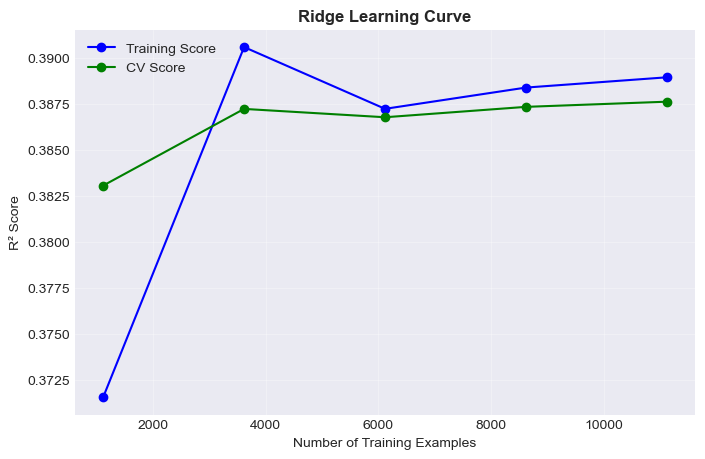

In [10]:
print("========== Chapter 7: Model Visualizations ==========")
print("Plots illustrate learning behavior, coefficient regularization, cross-validation error, and feature influence.\n")

# -------------------------------
# Fit all models first to ensure they are trained
# -------------------------------
ridge_cv.fit(X_train, y_train)
lasso_cv.fit(X_train, y_train)
elastic_cv.fit(X_train, y_train)

# -------------------------------
# 7.1 Learning Curve (Ridge)
# -------------------------------
print("----- Ridge Learning Curve -----")
print("Shows how training and cross-validation (CV) scores evolve with increasing training set size.\n")

from sklearn.model_selection import learning_curve

# Function to plot learning curves for any estimator
def plot_learning_curve(estimator, X, y, title="Learning Curve"):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
    )
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    
    plt.figure(figsize=(8,5))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
    plt.plot(train_sizes, test_mean, 'o-', color='green', label='CV Score')
    plt.title(title, fontsize=12, fontweight='bold')
    plt.xlabel("Number of Training Examples")
    plt.ylabel("R² Score")
    plt.legend(loc="best")
    plt.grid(alpha=0.3)
    plt.show()

# Plot the learning curve for Ridge Regression
plot_learning_curve(ridge_cv, X_train, y_train, title="Ridge Learning Curve")


----- Lasso Regularization Path -----
Illustrates how each feature coefficient changes as regularization strength (alpha) increases.



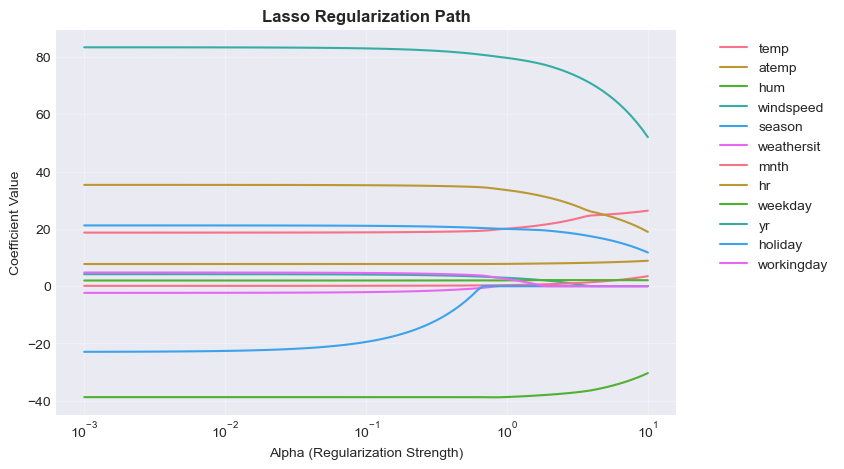

----- ElasticNet Regularization Path -----
Shows the combined L1/L2 regularization effect on feature coefficients.



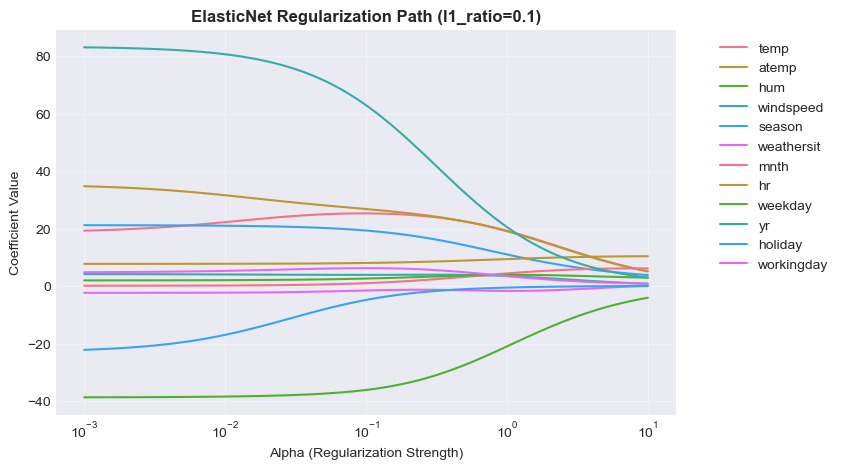

In [11]:
# -------------------------------
# 7.2 Regularization Paths
# -------------------------------
from sklearn.linear_model import lasso_path, enet_path

print("----- Lasso Regularization Path -----")
print("Illustrates how each feature coefficient changes as regularization strength (alpha) increases.\n")

# Compute Lasso regularization path
alphas_lasso, coefs_lasso, _ = lasso_path(X_train, y_train, alphas=np.logspace(-3, 1, 100))

plt.figure(figsize=(8,5))
for i in range(coefs_lasso.shape[0]):
    plt.plot(alphas_lasso, coefs_lasso[i,:], label=X_train.columns[i])
plt.xscale('log')
plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("Coefficient Value")
plt.title("Lasso Regularization Path", fontsize=12, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(alpha=0.3)
plt.show()

print("----- ElasticNet Regularization Path -----")
print("Shows the combined L1/L2 regularization effect on feature coefficients.\n")

# Compute ElasticNet regularization path
alphas_enet, coefs_enet, _ = enet_path(
    X_train, y_train, l1_ratio=elastic_cv.l1_ratio_, alphas=np.logspace(-3,1,100)
)

plt.figure(figsize=(8,5))
for i in range(coefs_enet.shape[0]):
    plt.plot(alphas_enet, coefs_enet[i,:], label=X_train.columns[i])
plt.xscale('log')
plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("Coefficient Value")
plt.title(f"ElasticNet Regularization Path (l1_ratio={elastic_cv.l1_ratio_})", fontsize=12, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(alpha=0.3)
plt.show()


----- ElasticNet Cross-Validation Curve -----
Shows cross-validation (CV) error for ElasticNet across alphas, confirming the best alpha and l1_ratio.



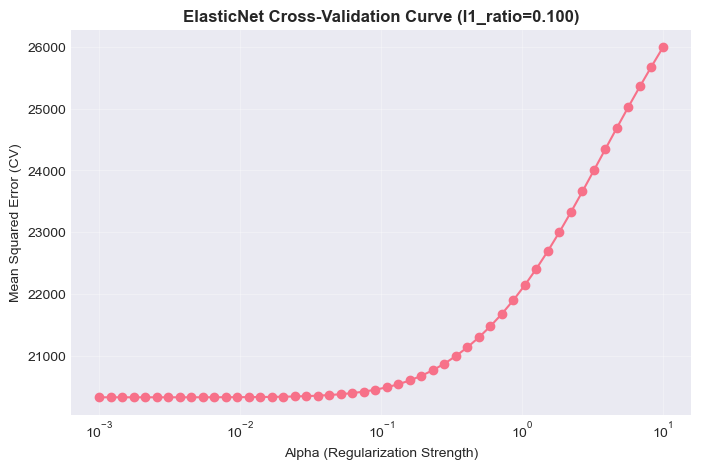

----- Feature Importance Across Models -----
Compares coefficients of Ridge, Lasso, and ElasticNet to highlight the most influential features.



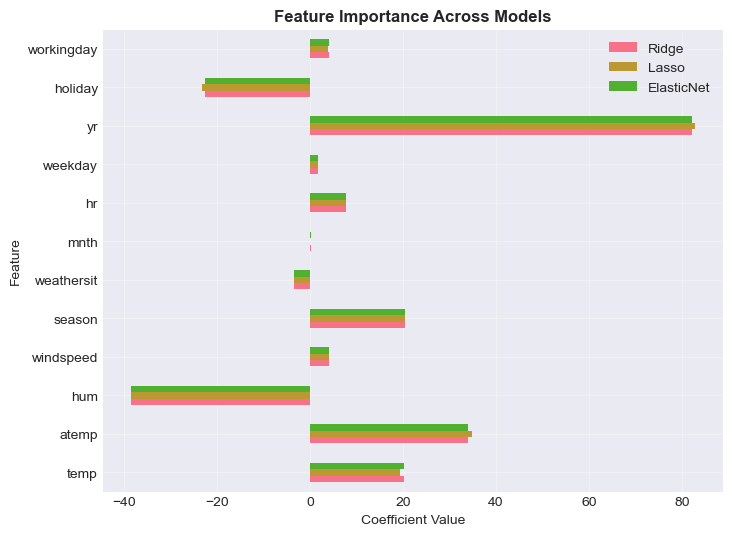

In [12]:
# ----- ElasticNet Cross-Validation Curve -----
print("----- ElasticNet Cross-Validation Curve -----")
print("Shows cross-validation (CV) error for ElasticNet across alphas, confirming the best alpha and l1_ratio.\n")

# 1. Find index of best l1_ratio
l1_ratios_tested = elastic_cv.l1_ratio
best_l1_ratio_value = elastic_cv.l1_ratio_
# np.where returns a tuple; [0][0] extracts the first index
best_idx = np.where(l1_ratios_tested == best_l1_ratio_value)[0][0]

# 2. Correctly compute mean CV error over folds for the selected l1_ratio
# Shape of mse_path_: (n_l1_ratios, n_alphas, n_folds)
# Select best l1_ratio (axis 0) and average over folds (axis 2)
mse_enet_mean = np.mean(elastic_cv.mse_path_[best_idx, :, :], axis=1)

# Plot the CV curve
plt.figure(figsize=(8,5))
plt.plot(elastic_cv.alphas_, mse_enet_mean, marker='o') 
plt.xscale('log')
plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("Mean Squared Error (CV)")
plt.title(f"ElasticNet Cross-Validation Curve (l1_ratio={best_l1_ratio_value:.3f})", fontsize=12, fontweight='bold')
plt.grid(alpha=0.3)
plt.show()

# -------------------------------
# 7.4 Feature Importance
# -------------------------------
print("----- Feature Importance Across Models -----")
print("Compares coefficients of Ridge, Lasso, and ElasticNet to highlight the most influential features.\n")

# Horizontal bar plot
# Create a DataFrame with feature names and coefficients from all three fitted models
coef_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Ridge": ridge_cv.coef_,
    "Lasso": lasso_cv.coef_,
    "ElasticNet": elastic_cv.coef_
})

# Set feature names as index and plot horizontal bar chart
coef_df.set_index("Feature").plot(kind='barh', figsize=(8,6))
plt.title("Feature Importance Across Models", fontsize=12, fontweight='bold')
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.grid(alpha=0.3)
plt.show()


# 8. STATISTICAL TESTING

In [13]:

cv_folds = 5  # Number of folds for cross-validation (consistent with Chapter 5)

# ----------------------------------------------------------------------------------
# STEP 1: Collect cross-validation (CV) scores for each model
# ----------------------------------------------------------------------------------
# These scores are needed for the statistical tests to compare model performance.

# Baseline: Ordinary Least Squares (OLS) regression
scores_baseline = cross_val_score(LinearRegression(), X_train, y_train, cv=cv_folds, scoring='r2')

# Ridge regression using the optimal alpha found in Chapter 5
scores_ridge = cross_val_score(Ridge(alpha=ridge_cv.alpha_), X_train, y_train, cv=cv_folds, scoring='r2')

# Lasso regression using the optimal alpha found in Chapter 5
scores_lasso = cross_val_score(Lasso(alpha=lasso_cv.alpha_), X_train, y_train, cv=cv_folds, scoring='r2')

# ElasticNet using the optimal alpha and l1_ratio found in Chapter 5
scores_elastic = cross_val_score(
    ElasticNet(alpha=elastic_cv.alpha_, l1_ratio=elastic_cv.l1_ratio_),
    X_train, y_train, cv=cv_folds, scoring='r2'
)

# ----------------------------------------------------------------------------------
# STEP 2: Pairwise statistical tests (compare OLS vs regularized models)
# ----------------------------------------------------------------------------------

# A. Wilcoxon Signed-Rank Test (non-parametric); does not assume normal distribution of differences.
# 'alternative="less"' checks if regularized models perform better than OLS.
w_ridge, p_w_ridge = stats.wilcoxon(scores_baseline, scores_ridge, alternative='less')
w_lasso, p_w_lasso = stats.wilcoxon(scores_baseline, scores_lasso, alternative='less')
w_elastic, p_w_elastic = stats.wilcoxon(scores_baseline, scores_elastic, alternative='less')

# B. Paired t-Test (parametric, as reference)
# Tests whether the mean difference of CV scores is significantly different from zero.
t_ridge, p_ridge = stats.ttest_rel(scores_baseline, scores_ridge)
t_lasso, p_lasso = stats.ttest_rel(scores_baseline, scores_lasso)
t_elastic, p_elastic = stats.ttest_rel(scores_baseline, scores_elastic)

# ----------------------------------------------------------------------------------
# STEP 3: Display results
# ----------------------------------------------------------------------------------

print("==========================================================")
print("Statistical Comparison (Wilcoxon & t-Test)")
print("==========================================================")
print(f"Baseline (OLS) mean R² over {cv_folds} folds: {np.mean(scores_baseline):.4f}\n")

# Create a summary table for all model comparisons
data = {
    'Model Pair': ['OLS vs Ridge', 'OLS vs Lasso', 'OLS vs ElasticNet'],
    'Wilcoxon W': [w_ridge, w_lasso, w_elastic],
    'Wilcoxon p-value': [p_w_ridge, p_w_lasso, p_w_elastic],
    't-Test t-stat': [t_ridge, t_lasso, t_elastic],
    't-Test p-value': [p_ridge, p_lasso, p_elastic]
}
results_df = pd.DataFrame(data)

# Format p-values for readability (scientific notation for very small values)
results_df['Wilcoxon p-value'] = results_df['Wilcoxon p-value'].apply(lambda x: f'{x:.4e}' if x < 0.001 else f'{x:.4f}')
results_df['t-Test p-value'] = results_df['t-Test p-value'].apply(lambda x: f'{x:.4e}' if x < 0.001 else f'{x:.4f}')

print(results_df.to_string(index=False))

print("\nInterpretation:")
print("A p-value < 0.05 indicates that the regularized model performs statistically significantly better than the OLS baseline.")

# Optional: mean R² scores per model for quick reference
mean_scores = pd.DataFrame({
    'Model': ['OLS', 'Ridge', 'Lasso', 'ElasticNet'],
    'Mean R² (CV)': [np.mean(scores_baseline), np.mean(scores_ridge), np.mean(scores_lasso), np.mean(scores_elastic)]
})
print("\nMean R² scores per model:")
print(mean_scores.to_string(index=False, float_format='%.4f'))


Statistical Comparison (Wilcoxon & t-Test)
Baseline (OLS) mean R² over 5 folds: 0.3876

       Model Pair  Wilcoxon W Wilcoxon p-value  t-Test t-stat t-Test p-value
     OLS vs Ridge         7.0           0.5000      -0.346389         0.7465
     OLS vs Lasso         8.0           0.5938      -0.090664         0.9321
OLS vs ElasticNet         7.0           0.5000      -0.406496         0.7052

Interpretation:
A p-value < 0.05 indicates that the regularized model performs statistically significantly better than the OLS baseline.

Mean R² scores per model:
     Model  Mean R² (CV)
       OLS        0.3876
     Ridge        0.3876
     Lasso        0.3876
ElasticNet        0.3876


# 9. RESULTS EXPORT

In [14]:
import os  # Provides functions to interact with the operating system

# Create a folder specifically for demo results (pre-OHE)
demo_results_dir = "results_demo_r2"
os.makedirs(demo_results_dir, exist_ok=True)

# Exporting only the mean R² scores for the demonstration (low R² scenario)
mean_scores_demo = mean_scores[['Model', 'Mean R² (CV)']]  # to keep only relevant columns
mean_scores_demo.to_csv(f"{demo_results_dir}/mean_r2_scores_demo.csv", index=False)

print(f"[INFO] Demo R² results saved in folder '{demo_results_dir}'.")
print("[INFO] These results correspond to the low R² scenario before proper preprocessing (no One-Hot Encoding) and are referenced in the paper for discussion purposes.")


[INFO] Demo R² results saved in folder 'results_demo_r2'.
[INFO] These results correspond to the low R² scenario before proper preprocessing (no One-Hot Encoding) and are referenced in the paper for discussion purposes.
